In [23]:
#import some stuff
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import random
import math
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim

In [32]:
# data source
data_dir = "C:/Users/yueze/Desktop/GPT_two_qubit_polarization_tracking/data.xlsx"

# select features used to predict targets
features = ["ch1", "ch2", "ch3"]
targets = ["norm1", "norm2", "norm3"]
df = pd.read_excel(data_dir, header=None).iloc[5:5881, :10]
df.columns = ["time", "ch1", "ch2", "ch3", "s1", "s2", "s3", "norm1", "norm2", "norm3"]
df["time"] = df["time"].apply(lambda str: datetime.strptime(str, "%H:%M:%S.%f").time())
df.head()

,time,ch1,ch2,ch3,s1,s2,s3,norm1,norm2,norm3
5,18:41:52.774000,-0.78125,-0.683594,-2.265625,-0.3125,-0.273438,-0.90625,0.38,0.48,0.79
6,18:41:52.870006,-0.78125,-0.683594,-2.255859,-0.3125,-0.273438,-0.902344,0.38,0.48,0.79
7,18:41:52.968011,-0.78125,-0.673828,-2.265625,-0.3125,-0.269531,-0.90625,0.38,0.47,0.79
8,18:41:53.070017,-0.78125,-0.673828,-2.255859,-0.3125,-0.269531,-0.902344,0.38,0.48,0.79
9,18:41:53.166023,-0.78125,-0.673828,-2.255859,-0.3125,-0.269531,-0.902344,0.38,0.48,0.79


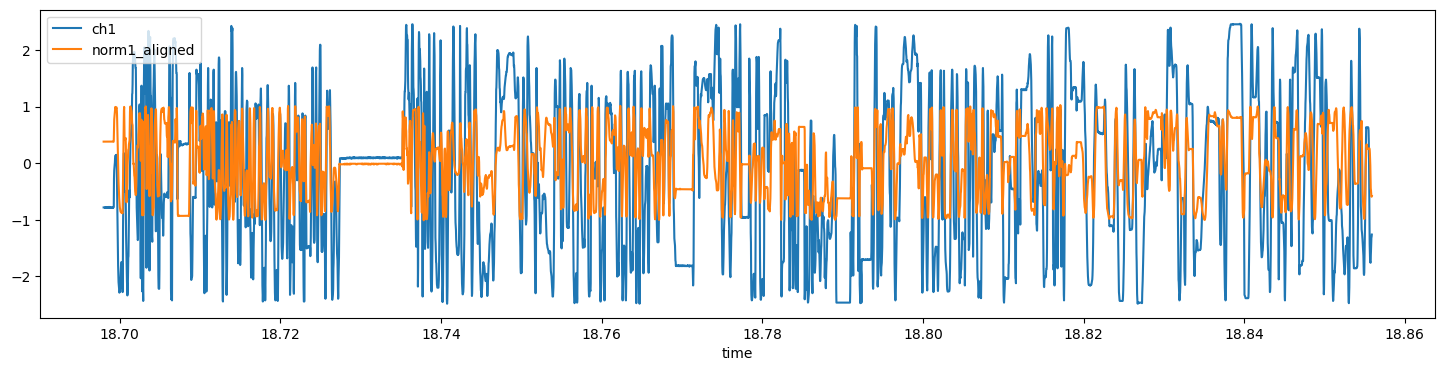

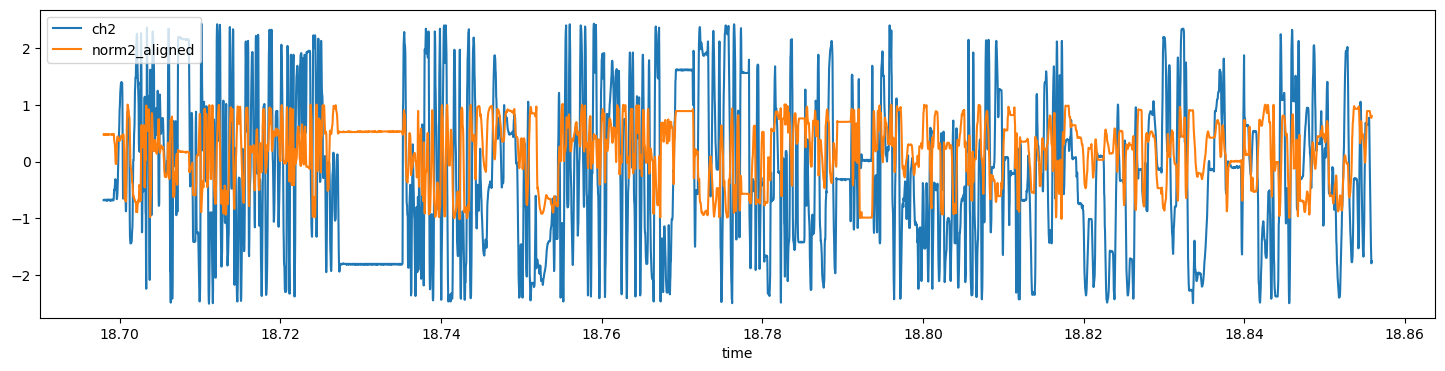

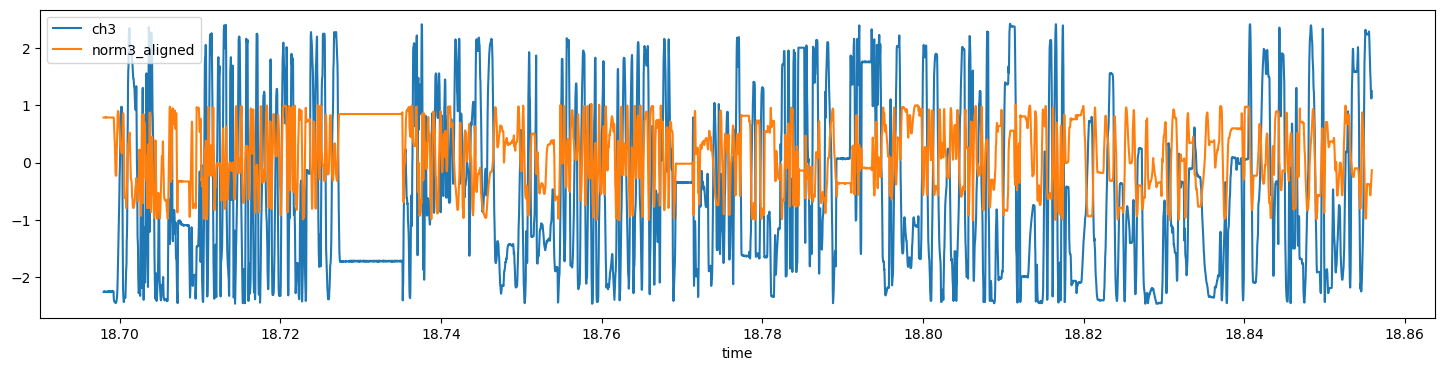

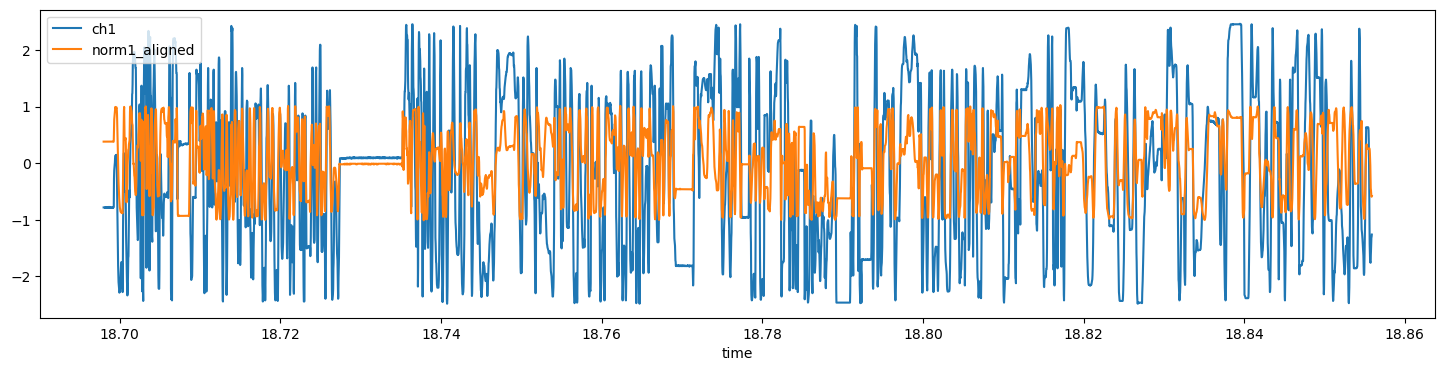

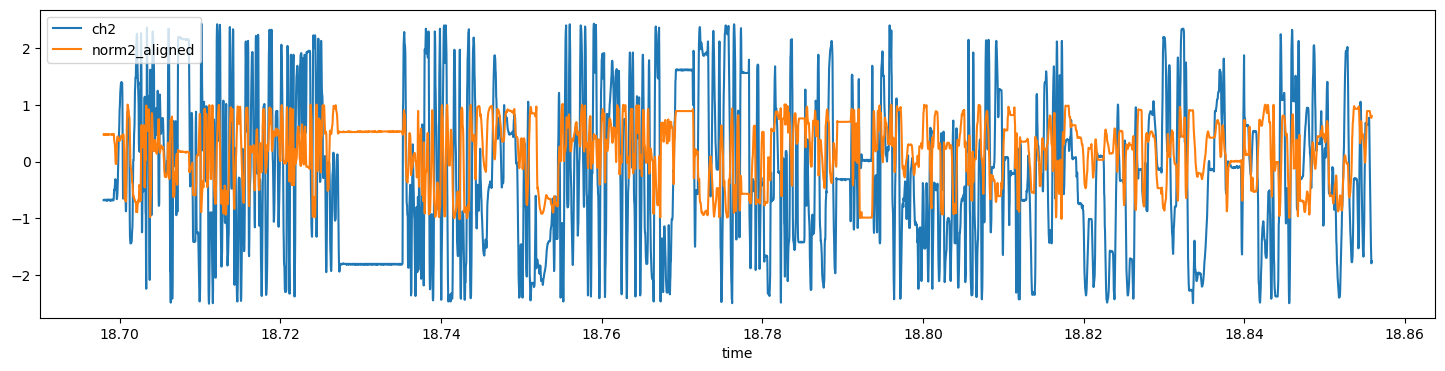

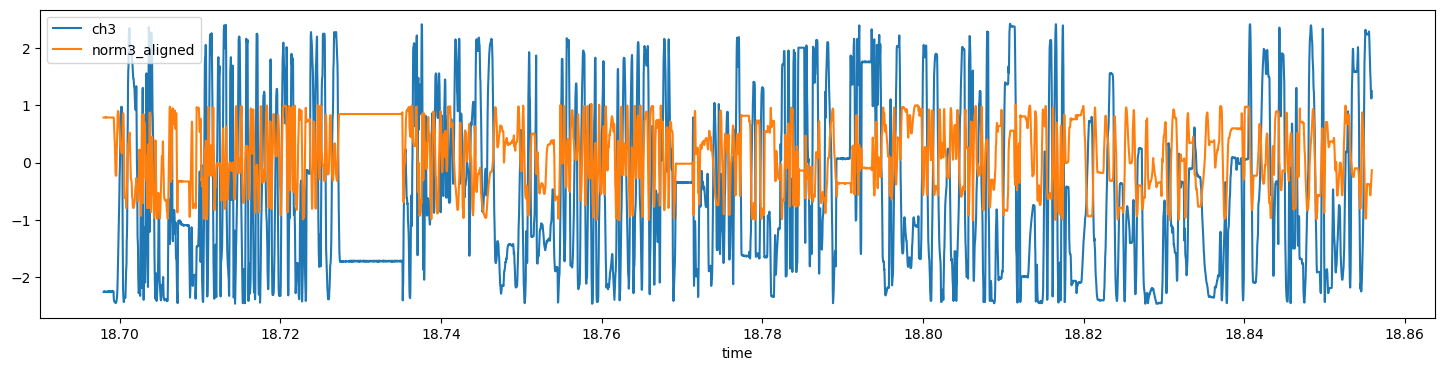

In [33]:
time = df["time"].apply(lambda t: t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3600000000)
# define stretching operation
def align(col, stretch_factor=1):
    return CubicSpline(np.arange(len(df)), df[col])(np.linspace(0, len(df) * (1 / stretch_factor), len(df)))
def plot_data(df, col1, col2, time, start=0, end=-1):
    plt.figure(figsize=(18, 4))
    plt.plot(time[start:end], df[col1][start:end], label=col1)
    plt.plot(time[start:end], df[col2][start:end], label=col2)
    plt.legend(loc="upper left")
    plt.xlabel("time")
    plt.show()
# test run with manual, visual alignment
for i in range(len(targets)):
    df[targets[i] + "_aligned"] = align(targets[i], 1.056)
    plot_data(df, features[i], targets[i] + "_aligned", time)
# define stretching operation
def align(col, stretch_factor=1):
    return CubicSpline(np.arange(len(df)), df[col])(np.linspace(0, len(df) * (1 / stretch_factor), len(df)))

# test run with manual, visual alignment
for i in range(len(targets)):
    df[targets[i] + "_aligned"] = align(targets[i], 1.056)
    plot_data(df, features[i], targets[i] + "_aligned", time)

In [42]:
#this begins attention section
x = df[features]  # Dropping original targets as we'll use aligned targets
y = df[[target + "_aligned" for target in targets]]  # Using aligned targets
split_idx = int(len(df) * 0.9)
length_read=len(df)
# Split into training and testing sets
x_train = x.iloc[:split_idx]
y_train = y.iloc[:split_idx]
x_test = x.iloc[split_idx:]
y_test = y.iloc[split_idx:]

In [43]:
print(x)
print(y)

           ch1       ch2       ch3
5     -0.78125 -0.683594 -2.265625
6     -0.78125 -0.683594 -2.255859
7     -0.78125 -0.673828 -2.265625
8     -0.78125 -0.673828 -2.255859
9     -0.78125 -0.673828 -2.255859
...        ...       ...       ...
5876 -1.445312 -1.640625  1.191406
5877 -1.318359 -1.796875  1.123047
5878 -1.298828 -1.757812  1.201172
5879 -1.259766 -1.757812      1.25
5880 -1.054688 -1.884766  1.259766

[5876 rows x 3 columns]
      norm1_aligned  norm2_aligned  norm3_aligned
5          0.380000       0.480000       0.790000
6          0.380000       0.480686       0.790000
7          0.380000       0.470052       0.790000
8          0.380000       0.478547       0.790001
9          0.380000       0.480303       0.789994
...             ...            ...            ...
5876      -0.545621       0.767959      -0.332347
5877      -0.586196       0.775621      -0.238741
5878      -0.591864       0.783269      -0.192070
5879      -0.583245       0.802628      -0.132705
5880 

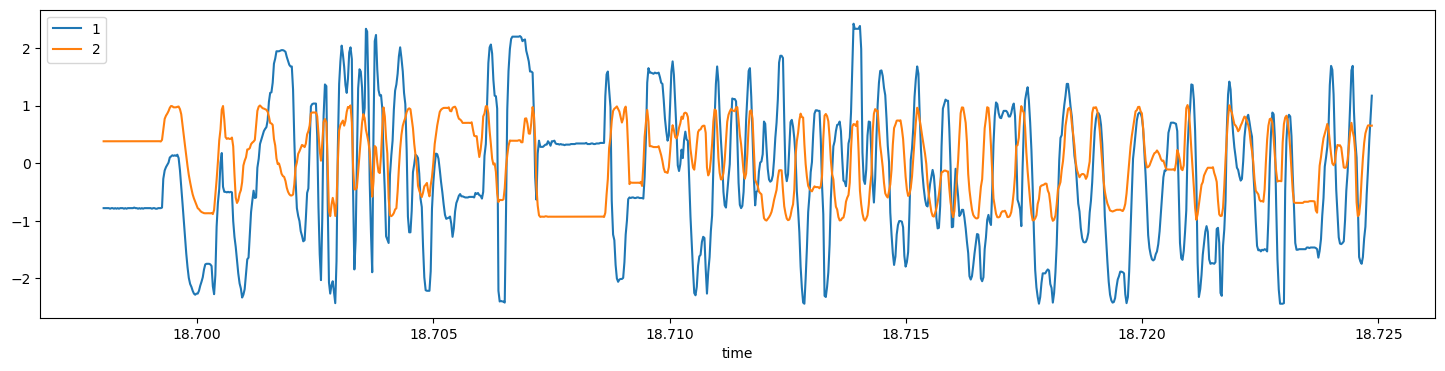

In [44]:
plt.figure(figsize=(18, 4))
plt.plot(time[1:1000], x["ch1"][1:1000], label="1")
plt.plot(time[1:1000], y["norm1_aligned"][1:1000], label="2")
plt.legend(loc="upper left")
plt.xlabel("time")
plt.show()

In [47]:
input_feature_dim = 3  # Each input element is a 1x3 vector
embed_size = 64
target_dim = 3
block_size = 20
num_heads = 16
max_iters = 300
batch_size = 10
eval_iters = 200
eval_interval = 1

def get_batch3(split):
    # Select the correct data split
    if split == 'train':
        a, b, max_index = x_train, y_train, int(length_read * 0.9) - block_size - 1
    else:  # split == 'test'
        a, b, max_index = x_test, y_test, length_read - (int(length_read * 0.9) + block_size + 1)
    
    # Generate random indices for batch selection, ensuring they're within bounds
    ix = torch.randint(0, max_index, (batch_size,))

    # Initialize lists to hold the batches
    x_batch = []
    y_batch = []

    for i in ix:
        try:
            # Extract the sequence from 'a' and the corresponding target from 'b'
            seq = torch.tensor(a.iloc[i.item():i.item() + block_size].astype(np.float32).values, dtype=torch.float32)
            target = torch.tensor(b.iloc[i.item() + block_size].astype(np.float32).values, dtype=torch.float32)
            x_batch.append(seq)
            y_batch.append(target)
        except IndexError as e:
            print(f"IndexError for index {i.item()}: {str(e)}")
            print(f"Attempting to access index [{i.item()}:{i.item() + block_size}] in 'a' with shape {a.shape}")
            print(f"Attempting to access index {i.item() + block_size} in 'b' with shape {b.shape}")
            # Optionally, break or continue depending on desired behavior on error
            break  # or continue

    if not x_batch or not y_batch:
        print("Error: Batch could not be created due to index issues.")
        return None, None
    
    # Stack the collected sequences and targets into tensors
    xstack = torch.stack(x_batch)
    ystack = torch.stack(y_batch)

    return xstack, ystack
class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        
    def forward(self, x):
        K = self.keys(x)
        Q = self.queries(x)
        V = self.values(x)
        
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.embed_size ** 0.5
        attention = torch.softmax(attention_scores, dim=-1)
        
        attended = torch.matmul(attention, V)
        return attended

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        
        assert embed_size % num_heads == 0
        
        self.head_dim = embed_size // num_heads
        
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        
        self.fc_out = nn.Linear(embed_size, embed_size)
    
    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        
        keys = self.keys(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        queries = self.queries(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        values = self.values(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        
        attention_scores = torch.einsum("bnqh,bnkh->bnqk", [queries, keys]) / (self.head_dim ** 0.5)
        attention = torch.softmax(attention_scores, dim=-1)
        
        attended = torch.einsum("bnqk,bnkv->bnqv", [attention, values]).reshape(batch_size, seq_length, self.embed_size)
        
        output = self.fc_out(attended)
        return output
        
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch3(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
    
class EncoderWithFullyConnected(nn.Module):
    def __init__(self, input_feature_dim, embed_size, seq_length, num_heads):
        super(EncoderWithFullyConnected, self).__init__()
        self.input_fc = nn.Linear(input_feature_dim, embed_size)
        self.multi_head_attention = MultiHeadAttention(embed_size, num_heads)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, embed_size))
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.input_fc(x)) + self.positional_encoding
        x = self.multi_head_attention(x)
        return x

class EncoderDecoderModelWithMultiHeadAttention(nn.Module):
    def __init__(self, input_feature_dim, embed_size, target_dim, seq_length, num_heads):
        super(EncoderDecoderModelWithMultiHeadAttention, self).__init__()
        self.encoder = EncoderWithFullyConnected(input_feature_dim, embed_size, seq_length, num_heads)
        self.decoder = nn.Sequential(
            nn.Linear(embed_size, target_dim),
        )

    def forward(self, x,targets):
        encoded = self.encoder(x)
        encoded_pooled = torch.mean(encoded, dim=1)
        decoded = self.decoder(encoded_pooled)

        loss = criterion(decoded, targets)

        return decoded,loss
        


In [48]:
if __name__ == "__main__":
    model = EncoderDecoderModelWithMultiHeadAttention(input_feature_dim, embed_size, target_dim, block_size, num_heads)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    for iter in range(max_iters):
    
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
        # sample a batch of data
        xb, yb = get_batch3('train')
        predictions,loss = model(xb,yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    print("Loss:", loss.item())

step 0: train loss 0.3254, val loss 0.3342
step 1: train loss 0.3230, val loss 0.3283
step 2: train loss 0.3183, val loss 0.3246
step 3: train loss 0.3143, val loss 0.3184
step 4: train loss 0.3137, val loss 0.3177
step 5: train loss 0.3129, val loss 0.3147
step 6: train loss 0.3112, val loss 0.3187
step 7: train loss 0.3128, val loss 0.3160
step 8: train loss 0.3046, val loss 0.3205
step 9: train loss 0.3038, val loss 0.3175
step 10: train loss 0.3060, val loss 0.3225
step 11: train loss 0.3089, val loss 0.3196
step 12: train loss 0.2957, val loss 0.3287
step 13: train loss 0.3034, val loss 0.3287
step 14: train loss 0.3042, val loss 0.3296
step 15: train loss 0.3045, val loss 0.3332
step 16: train loss 0.3064, val loss 0.3317
step 17: train loss 0.2993, val loss 0.3367
step 18: train loss 0.2986, val loss 0.3350
step 19: train loss 0.3023, val loss 0.3348
step 20: train loss 0.3068, val loss 0.3312
step 21: train loss 0.3044, val loss 0.3340
step 22: train loss 0.3007, val loss 0.336